In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pylab as pylab

# Useful plotting thingies:
%matplotlib inline
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = 12, 8


In [33]:
from sklearn.cross_validation import StratifiedShuffleSplit
# Set up the experimental matrices:
targets = ['ADAS11_bl', 'ADAS13_bl', 'MMSE_bl']
targets_regex = '|'.join(['^{}$'.format(t) for t in targets])
#modalities = ['CT_', 'L_HC_', 'R_HC_', 'AGE']
modalities = ['CT_', 'AGE', 'PTGENDER']
modalities_regex = '|'.join(['^{}'.format(m) for m in modalities])

frame = pd.read_csv('/projects/francisco/data/ADNI/master_fused.csv')
# Recode PTGENDER
frame['PTGENDER'] = [0 if 'Female' in x else 1 for x in frame['PTGENDER']]
X_cur = frame.filter(regex=modalities_regex).as_matrix()
y_cur = frame.filter(regex=targets_regex).as_matrix()
# Replaces nans with mean: revisit this later
y_cur[np.isnan(y_cur)] = np.nanmean(y_cur)


var_names = frame.filter(regex=modalities_regex).columns


split = StratifiedShuffleSplit(frame['DX_bl'], n_iter=1)
for t, v in split:
    tind, vind = t, v
X = X_cur[tind,:]
y = y_cur[tind,:]
X_v = X_cur[vind,:]
y_v = y_cur[vind,:]


print X.shape, y.shape
print X_v.shape, y_v.shape
print np.sum(np.isnan(y))
print var_names

(629, 76) (629, 3)
(69, 76) (69, 3)
0
Index([u'AGE', u'PTGENDER', u'CT_REC.L', u'CT_OLF.L', u'CT_ORBsup.L',
       u'CT_ORBsupmed.L', u'CT_ORBmid.L', u'CT_ORBinf.L', u'CT_SFGdor.L',
       u'CT_MFG.L', u'CT_IFGoperc.L', u'CT_IFGtriang.L', u'CT_SFGmed.L',
       u'CT_SMA.L', u'CT_PCL.L', u'CT_PreCG.L', u'CT_ROL.L', u'CT_PoCG.L',
       u'CT_SPG.L', u'CT_IPL.L', u'CT_SMG.L', u'CT_ANG.L', u'CT_PCUN.L',
       u'CT_SOG.L', u'CT_MOG.L', u'CT_IOG.L', u'CT_CAL.L', u'CT_CUN.L',
       u'CT_LING.L', u'CT_FFG.L', u'CT_HES.L', u'CT_STG.L', u'CT_MTG.L',
       u'CT_ITG.L', u'CT_TPOsup.L', u'CT_TPOmid.L', u'CT_ACG.L', u'CT_DCG.L',
       u'CT_PCG.L', u'CT_REC.R', u'CT_OLF.R', u'CT_ORBsup.R',
       u'CT_ORBsupmed.R', u'CT_ORBmid.R', u'CT_ORBinf.R', u'CT_SFGdor.R',
       u'CT_MFG.R', u'CT_IFGoperc.R', u'CT_IFGtriang.R', u'CT_SFGmed.R',
       u'CT_SMA.R', u'CT_PCL.R', u'CT_PreCG.R', u'CT_ROL.R', u'CT_PoCG.R',
       u'CT_SPG.R', u'CT_IPL.R', u'CT_SMG.R', u'CT_ANG.R', u'CT_PCUN.R',
       u'CT_SOG.R

In [35]:
from sklearn.linear_model import SGDRegressor, BayesianRidge, RidgeCV
from sklearn.decomposition import RandomizedPCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_regression
from sklearn import metrics

#k_nums = [2**x for x in range(1,12)]
#k_nums.append(X.shape[1])
#k_nums = [16, 32, 64, 128, 512, 1024, 1512, 2048, 3128, 4096]
k_nums = range(1, X.shape[1], 5)
k_nums.append(X.shape[1])
k_classifiers = []
stats = np.zeros(shape=(len(k_nums), 3, 2, len(targets)))
for i, k in enumerate(k_nums):
    for t in range(0,len(targets)):
        sel = SelectKBest(f_regression, k=k)
        classifier = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=None, fit_intercept=True, scoring=None, normalize=True)
        #sel = RFE(classifier, n_features_to_select=k)
        
        bayes_classifier = BayesianRidge(compute_score=True, normalize=True)
        #bsel = RFE(bayes_classifier, n_features_to_select=k)
        classifiers = [classifier, bayes_classifier]
        
        # Feature Selection
        sel.fit(X,y[:,t])
        support = sel.get_support(indices=True)
        #support = range(k)
        # Feature transformatio
        X_hat_v = sel.transform(X_v)

        # Train classifiers
        classifier.fit(X_hat_v, y_v[:,t])
        bayes_classifier.fit(X_hat_v, y_v[:,t])
        k_classifiers.append((classifier, bayes_classifier))

        # Predict on validation data and log stats   
        for l, c in enumerate(classifiers):
            y_hat_v = c.predict(X_hat_v)
            stats[i,0,l,t] = k
            stats[i,1,l,t] =  metrics.mean_squared_error(y_hat_v, y_v[:,t])
            stats[i,2,l,t] =  metrics.r2_score(y_hat_v, y_v[:,t])



In [41]:
T = 1 # Current target index

k = stats[:,0,0]
rss = stats[:,1,0]
brss = stats[:,1,1]
vs = stats[:,2,0]
bvs = stats[:,2,1]
stats_table = np.zeros(shape=(len(k_nums), 5, 3))
for i in range(3):
    stats_table[:,:,i] = np.vstack([k[:,i], rss[:,i], brss[:,i], vs[:,i], bvs[:,i]]).T
stats_table.shape

(16, 3)


In [37]:
from tabulate import tabulate
for i in range(3):
    print
    print 'Y: {}'.format(targets[i])
    print tabulate(stats_table[:,:,i], ['K', 'MSE', 'Bayes_MSE', 'R2', 'Bayes_R2'])



Y: ADAS11_bl
  K      MSE    Bayes_MSE         R2    Bayes_R2
---  -------  -----------  ---------  ----------
  1  25.4935      25.4758  -4.79121    -4.53301
  6  18.9597      19.3911  -0.872583   -1.15141
 11  19.6022      18.4034  -1.76976    -1.01138
 16  18.6092      17.5964  -1.27439    -0.852247
 21  18.2433      17.5897  -1.21167    -0.941127
 26  17.5178      16.7247  -1.08315    -0.809806
 31  17.1274      16.743   -1.00746    -0.87646
 36  16.9916      17.3071  -0.996055   -1.10646
 41  16.6789      17.4263  -0.914092   -1.18683
 46  16.3995      17.5831  -0.867837   -1.30298
 51  15.6552      16.91    -0.728553   -1.1502
 56  15.0981      16.5254  -0.611907   -1.05556
 61  14.2736      15.2673  -0.4789     -0.750482
 66  13.9706      15.2563  -0.433222   -0.777858
 71  13.366       14.5802  -0.341301   -0.64664
 76  13.1571      14.9539  -0.309321   -0.775313

Y: ADAS13_bl
  K      MSE    Bayes_MSE        R2    Bayes_R2
---  -------  -----------  --------  ----------
  1  

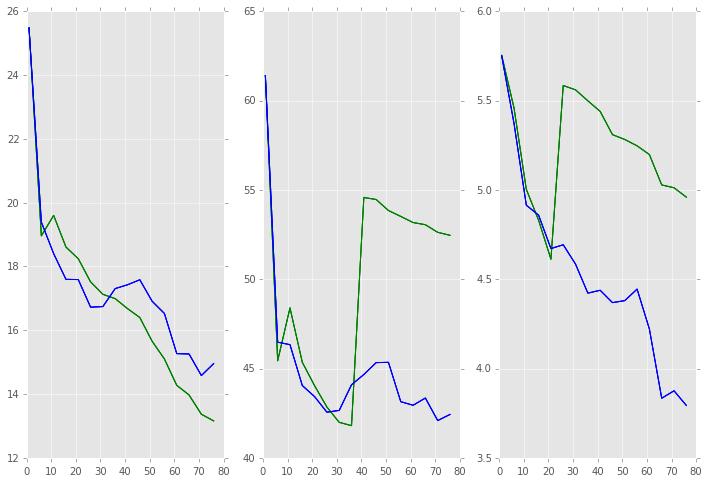

In [46]:
plt.figure(1)
plt.cla()
plt.xscale('log')
plt.yscale('log')
plt.xticks(k_nums, k_nums)
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(k, rss[:,i], 'g', label='logreg')
    plt.plot(k, brss[:, i], 'b', label='bayesian reg')


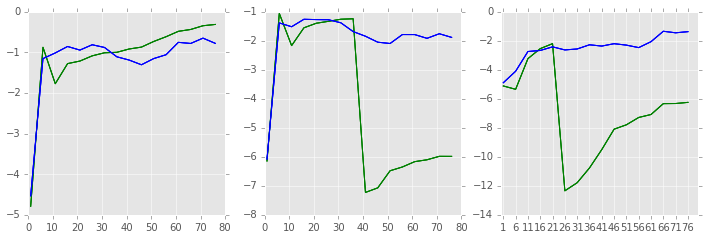

In [47]:
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.plot(k, vs[:,i], 'g', label='logreg')
    plt.plot(k, bvs[:, i], 'b', label='bayesian reg')
    
plt.xticks(k_nums, k_nums)
plt.show()

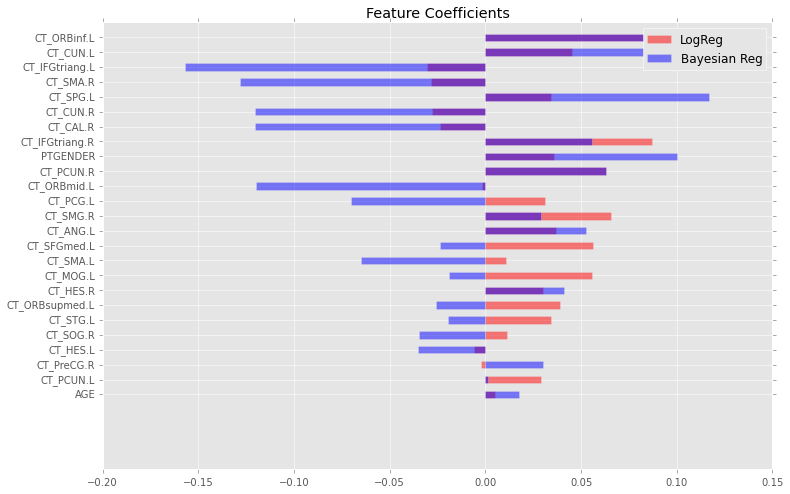

In [40]:
# Pick a classifier, plot the feature weights
classifiers_pair = k_classifiers[-1]
c = classifiers_pair[0]
b = classifiers_pair[1]
feats = zip(var_names[support], c.coef_, b.coef_)
feats.sort(reverse=False, key=lambda x: abs(x[1]) + abs(x[2]))
feats = feats[0:25]
# Plot the feature importances of the classifier
plt.figure()
plt.title("Feature Coefficients")
y_pos = np.arange(len(feats))
plt.barh(y_pos, width=zip(*feats)[1], height=0.5, color='r', align="center", alpha=0.5, label='LogReg')
plt.barh(y_pos, width=zip(*feats)[2], height=0.5, color='b', align="center", alpha=0.5, label='Bayesian Reg')
plt.yticks(y_pos, zip(*feats)[0])
plt.legend()
plt.show()